**Author:** Jessica Bosch

**Last Modified:** July 24, 2022

# Problem Discription

## 2009 RECS Survey Data

[[Source](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata)]: "This 2009 version represents the 13th iteration of the RECS program. First conducted in 1978, the Residential Energy Consumption Survey is a national sample survey that collects energy-related data for housing units occupied as a primary residence and the households that live in them. Data were collected from 12,083 households selected at random using a complex multistage, area-probability sample design. The sample represents 113.6 million U.S. households, the Census Bureau’s statistical estimate for all occupied housing units in 2009 derived from their American Community Survey (ACS).

Data are available in two formats: CSV, a comma delimited file and a SAS data file. The comma delimited data file is accompanied by a corresponding "Layout file", which contains descriptive labels and formats for each data variable. The "Variable and response codebook" file contains descriptive labels for variables, descriptions of the response codes, and indicators for the variables used in each end-use model.

Users are strongly encouraged to read [Using the 2009 microdata file to compute estimates and standard errors (RSEs)](https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf)."

## Task
Build a model that predicts consumption. The electric consumption is located in the `KWH` field.


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# train and test split
from sklearn.model_selection import train_test_split

# feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# linear regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# metrics
from sklearn.metrics import mean_squared_error

In [2]:
# display all dataframe columns in the notebook
pd.options.display.max_columns = None

# set figure size
plt.rcParams['figure.figsize'] = (8, 6)

# Data Preparation

## Read Data

In [3]:
# read data
df = pd.read_csv('data/recs2009_public.csv')

C:\Users\Jessica Bosch\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# check the columns from the above warning
for col in ['NOCRCASH','NKRGALNC']:
    print(col, ': ', df[col].unique(), df[col].dtype)

NOCRCASH :  [-2 1 6 15 4 '-2' '1' '20' '.' '12' '4' '10' '3' '24' '55' '6' 8 28 5 55 3
 16 2 20 10 24 40 12 25] object
NKRGALNC :  [-2 1 5 10 '-2' '10' '15' '1' '8' '.' '5' '3' '2' '77' 30 3 15 8 55 2 20] object


In [5]:
# check the columns from the above warning
for col in ['NOCRCASH','NKRGALNC']:
    print(df[col].value_counts(normalize=True).head()*100.)

-2    82.413308
-2    16.783911
1      0.148970
3      0.082761
4      0.082761
Name: NOCRCASH, dtype: float64
-2    82.413308
-2    16.783911
5      0.347596
3      0.091037
1      0.082761
Name: NKRGALNC, dtype: float64


99% of the values in `NOCRCASH` and `NKRGALNC` are `-2` ("Not Applicable"). Hence, we can remove these two columns.

In [6]:
# create a new dataframe df_clean which will be the cleaned version of the original dataframe df
df_clean = df.copy()

# remove the columns from the warning
print(df_clean.shape)
df_clean.drop(columns=['NOCRCASH','NKRGALNC'], inplace=True)
print(df_clean.shape)

(12083, 940)
(12083, 938)


The remaining data has 938 columns and 12,083 rows. Data cleaning is crucial to reduce the number of dimensions.

## Check for Duplicates

In [7]:
# check for duplicates
df_clean[df_clean.duplicated()].shape

(0, 938)

There are no duplicate rows.

## Check for Missing Values

In [8]:
# count missing values
df_clean.isna().sum().sum()

0

There are no missing (NaN) values.

As written in [Using the 2009 microdata file to compute estimates and standard errors (RSEs)](https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf): "Most variables were imputed for “Don’t Know” and “Refuse” responses. The "Z variables", also referred to as "imputation flags", are included in the public use microdata file. EIA recommends using the imputed data, where available to avoid biased estimation."

We will remove the "Z variables":

In [9]:
# list of "Z variables"
z_variables = list(df_clean.columns[df_clean.columns.str.startswith('Z')])

In [10]:
# remove the "Z variables"
print(df_clean.shape)
df_clean.drop(columns=z_variables, inplace=True)
print(df_clean.shape)

(12083, 938)
(12083, 579)


We have reduced the dimensions from 938 to 579.

As written in [Using the 2009 microdata file to compute estimates and standard errors (RSEs)](https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf): "Variables that were not imputed use the response codes -9 for “Don’t Know” and -8 for “Refuse”. Variables that are not asked of all respondents use the response code -2 for “Not Applicable”. For example, if a respondent said they did not use any computers at home (COMPUTER = 0) then they were not asked what type of computer is most used at home, thus PCTYPE1 = -2. Use caution when performing calculations on variables that may have -2, -8, or -9 responses."

As written in [The Problem of Missing Data](https://towardsdatascience.com/the-problem-of-missing-data-9e16e37ef9fc):
"There are some strategies for handling missing data, like identify nonrespondents by creating one or more special codes for those entries of the data matrix that are not observed, such as “don’t know” or “refuse to answer”, another way is excluding units that have missing value. This last strategy is very inappropriate because we are usually interested in making inferences about the entire target population, rather than the portion of the target population of some dataset."

Hence, we will follow the advice and keep the `-2`, `-8`, and `-9` responses. For our prediction task and due to limited time available, we will replace the `-2`, `-8`, and `-9` responses with the median values of each column. But a more comprehensive analysis and treatment is recommended.

## Handle Don’t Know/Refuse/Not Applicable Responses

In [11]:
# list of columns that have Don't Know/Refuse/Not Applicable responses
nan_cols = [col for col in df_clean.columns if 
            (-2 in df_clean[col].unique()) |
            (-8 in df_clean[col].unique()) |
            (-9 in df_clean[col].unique())]
len(nan_cols)

347

In [12]:
# replace Don't Know/Refuse/Not Applicable responses with the median values
for col in nan_cols:
    df_clean[col] = np.where(df_clean[col].isin([-2,-8,-9]),
                             df_clean[~(df_clean[col].isin([-2,-8,-9]))][col].median(),
                             df_clean[col])

## Remove Nonrelevant Columns

In [13]:
# remove the unique identifier 'DOEID'
print(df_clean.shape)
df_clean.drop(columns=['DOEID'], inplace=True)
print(df_clean.shape)

(12083, 579)
(12083, 578)


## Analyze Variables Correlated to the Target `KWH`

### Identify all `KWH`-related Variables

In [14]:
# look at all 'KWH'-variables
kwh_variables = list(df_clean.columns[df_clean.columns.str.contains('KWH')])
df_clean[kwh_variables].head()

,KWH,KWHSPH,KWHCOL,KWHWTH,KWHRFG,KWHOTH
0,18466,3186.71,3068.80,2968.45,1515.50,7726.55
1,5148,0.00,182.00,0.00,1310.22,3655.78
2,2218,0.00,184.46,0.00,915.66,1117.88
3,10015,0.00,1063.02,1887.53,1670.53,5393.91
4,2869,0.00,0.00,0.00,346.47,2522.53


Our target `KWH` is the sum of `KWHSPH`, `KWHCOL`, `KWHWTH`, `KWHRFG`, and `KWHOTH`. Hence, we will remove `KWHSPH`, `KWHCOL`, `KWHWTH`, `KWHRFG`, and `KWHOTH`.

In [15]:
# drop KWHSPH, KWHCOL, KWHWTH, KWHRFG, and KWHOTH
print(df_clean.shape)
kwh_variables.remove('KWH')
df_clean.drop(columns=kwh_variables, inplace=True)
print(df_clean.shape)

(12083, 578)
(12083, 573)


### Identify Strong Correlations

We use the following correlation criteria:
- Strong: > 0.7
- Moderate: 0.5-0.7
- Weak: 0.3-0.5
- None or weak: < 0.3

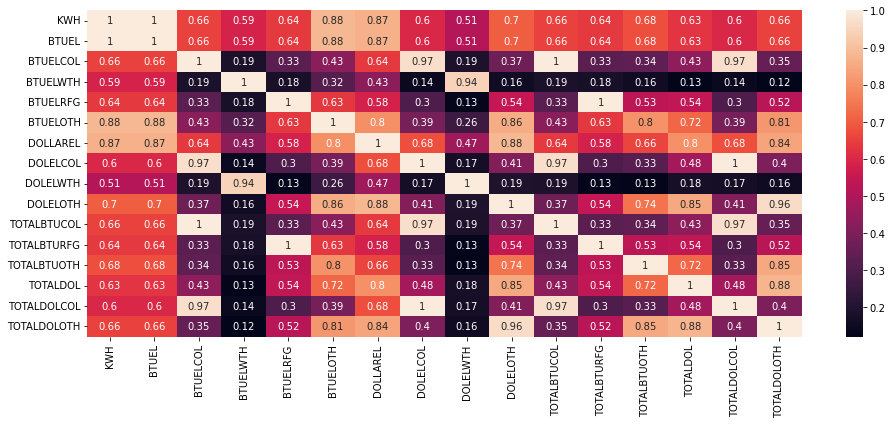

In [16]:
## look at moderate to strong correlations to our target 'KWH'

# create correlation dataframe df_corr
df_corr = df_clean.corr()

# filter correlation dataframe to moderate to strong correlations to our target 'KWH'
relevant_cols = list(df_corr[abs(df_corr['KWH'])>=0.5].index)

# heatmap plot of the resulting correlations
plt.figure(figsize=(16, 6))
sns.heatmap(df_corr[relevant_cols][abs(df_corr['KWH'])>=0.5], annot=True);

There is a perfect positive correlation between our target `KWH` and `BTUEL`.

In fact, all `BTUEL`-variables do also represent electrical usage (in thousand BTU). Hence, we will drop all variables whose names start with `BTUEL` or `TOTALBTU`:

In [17]:
# look at the columns we are about to drop and see their relationships
btuel_variables = list(df_clean.columns[(df_clean.columns.str.startswith('BTUEL')) | 
                                        (df_clean.columns.str.startswith('TOTALBTU'))])

df_clean[btuel_variables].head()

,BTUEL,BTUELSPH,BTUELCOL,BTUELWTH,BTUELRFG,BTUELOTH,TOTALBTU,TOTALBTUSPH,TOTALBTUCOL,TOTALBTUWTH,TOTALBTURFG,TOTALBTUOTH
0,63006,10873.05,10470.73,10128.35,5170.90,26362.97,63006,10873,10471,10128,5171,26363
1,17565,0.00,620.98,0.00,4470.48,12473.54,103460,38606,621,30110,4470,29653
2,7568,0.00,629.39,0.00,3124.32,3814.29,58716,40248,629,7933,3124,6781
3,34171,0.00,3627.01,6440.22,5699.83,18403.93,76401,40196,3627,6440,5700,20438
4,9789,0.00,0.00,0.00,1182.14,8606.86,59809,36136,0,13884,1182,8607


In [18]:
# drop 'BTUEL'-variables and 'TOTALBTU'-variables
print(df_clean.shape)
df_clean.drop(columns=btuel_variables, inplace=True)
print(df_clean.shape)

(12083, 573)
(12083, 561)


Next, we noticed above that there are cost variables, indicated by containing `DOL` in their names, which are strongly correlated to our target `KWH`. 
Among them, `KWH` has the strongest correlation with `DOLLAREL`.

Let's check the relationships among the cost variables:

In [19]:
# look at cost variables and see their relationships
dol_variables = list(df_clean.columns[((df_clean.columns.str.contains('EL')) & 
                                          (df_clean.columns.str.contains('DOL'))) |
                                        (df_clean.columns.str.startswith('TOTALDOL'))])
df_clean[dol_variables].head()

,DOLLAREL,DOLELSPH,DOLELCOL,DOLELWTH,DOLELRFG,DOLELOTH,TOTALDOL,TOTALDOLSPH,TOTALDOLCOL,TOTALDOLWTH,TOTALDOLRFG,TOTALDOLOTH
0,1315,226.93,218.54,211.39,107.92,550.22,1315,227,219,211,108,550
1,475,0.00,16.79,0.00,120.89,337.32,1293,368,17,287,121,501
2,588,0.00,48.90,0.00,242.75,296.35,1327,582,49,115,243,339
3,952,0.00,101.05,179.42,158.80,512.73,1398,425,101,179,159,534
4,705,0.00,0.00,0.00,85.14,619.86,1558,616,0,237,85,620


`DOLLAREL` is the sum of `DOLELSPH`, `DOLELCOL`, `DOLELWTH`, `DOLELRFG`, and `DOLELOTH`. Hence, we will remove `DOLELSPH`, `DOLELCOL`, `DOLELWTH`, `DOLELRFG`, and `DOLELOTH`. Among them, `KWH` has the strongest correlation with `DOLLAREL`.

`TOTALDOL` is the sum of `TOTALDOLSPH`, `TOTALDOLCOL`, `TOTALDOLWTH`, `TOTALDOLRFG`, and `TOTALDOLOTH`. Among them, `KWH` has the strongest correlation with `TOTALDOLOTH`.

Since `DOLLAREL` and `TOTALDOLOTH` are strongly correlated, we will only keep `DOLLAREL` among these cost variables.

In [20]:
# drop nonrelevant cost variables
print(df_clean.shape)
dol_variables.remove('DOLLAREL')
df_clean.drop(columns=dol_variables, inplace=True)
print(df_clean.shape)

(12083, 561)
(12083, 550)


## Remove Multicollinearity

In [21]:
# repeat the correlation calculation from above (but exclude the target variable 'KWH')

# create correlation dataframe df_corr
df_corr = df_clean.drop(columns='KWH').corr()

# create dictionary that contains all strongly correlated variables
high_corr = {}
i=1
for col in df_corr.columns:
    high_corr_list = list(df_corr.iloc[i:][(abs(df_corr.iloc[i:][col])>0.7)].index)
    
    if len(high_corr_list) > 0:
        high_corr[col] = high_corr_list
        
    i=i+1

In [22]:
# drop strongly correlated columns

print(df_clean.shape)

removed_cols = []
for key, value in high_corr.items():
    if key in removed_cols:
        continue
    cols_to_drop = [col for col in value if col not in removed_cols]
    df_clean.drop(columns=cols_to_drop, inplace=True)
    removed_cols = removed_cols + cols_to_drop
    
print(df_clean.shape)

(12083, 550)
(12083, 439)


We have reduced the dimensions from 550 to 439.

## Remove Biased Responses

In [23]:
# check for variables where a specific value has more than 85% of the responses

biased_cols = {}
for col in df_clean.drop(columns='KWH').columns:
    biased_value = 100.*df_clean[col].value_counts().iloc[0]/df_clean.shape[0]
    if biased_value > 85:
        biased_cols[col] = biased_value

len(biased_cols)

268

In [24]:
# remove those biased variables
print(df_clean.shape)
df_clean.drop(columns=biased_cols, inplace=True)
print(df_clean.shape)

(12083, 439)
(12083, 171)


We have reduced the dimensions from 439 to 171.

## Handle Outliers

We compare outlier treatments using (a) the IQR and (b) the z-score.

In [25]:
# function that checks the percentage of outliers based on the IQR

def detect_outliers_iqr(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_list = [x for x in data[col] if ((x < lower_range) | (x > upper_range))]
    
    return 100.*len(outlier_list)/data.shape[0]

In [26]:
# function that checks the percentage of outliers based on the z-score

def detect_outliers_zscore(data, col):
    zscore = np.abs(stats.zscore(data[col]))
    outlier_list = np.where(zscore>3,True,False)
    
    return 100.*outlier_list.sum()/data.shape[0]

In [27]:
# function that cleans outliers based on the IQR by replacing outliers with median values
# if the original column was of type 'int', we make sure it will be of type 'int' after the cleaning

def clean_outliers_iqr(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    
    int_type = False
    
    if (data[col].dtype=='int64') | (data[col].dtype=='int32') | (data[col].dtype==int):
        int_type = True

    data[col] = np.where((data[col] < lower_range) | (data[col] > upper_range),
                         data[col].median(),
                         data[col])
    
    if int_type:
        data[col] = data[col].astype('int64')

In [28]:
# function that cleans outliers based on the z-score by replacing outliers with median values
# if the original column was of type 'int', we make sure it will be of type 'int' after the cleaning

def clean_outliers_zscore(data, col):
    int_type = False
    
    if (data[col].dtype=='int64') | (data[col].dtype=='int32') | (data[col].dtype==int):
        int_type = True

    data[col] = np.where(np.abs(stats.zscore(data[col]))>3,
                         data[col].median(),
                         data[col])
    
    if int_type:
        data[col] = data[col].astype('int64')

In [30]:
# list of columns that we will check for outliers (we exclude variables with a low number of unique values)
outliers = [col for col in df_clean[df_clean.select_dtypes(include='number').columns].columns if 
            df_clean[col].nunique()>=8]
len(outliers)

49

In [31]:
# calculate percentage of outliers for the identified columns using the detect_outliers_iqr() function
outlier_iqr_dic = {}
for col in outliers:
    outlier_val = detect_outliers_iqr(df_clean, col)
    if outlier_val > 0:
        outlier_iqr_dic[col] = outlier_val

In [32]:
# calculate percentage of outliers for the identified columns using the detect_outliers_zscore() function
outlier_zscore_dic = {}
for col in outliers:
    outlier_val = detect_outliers_zscore(df_clean, col)
    if outlier_val > 0:
        outlier_zscore_dic[col] = outlier_val

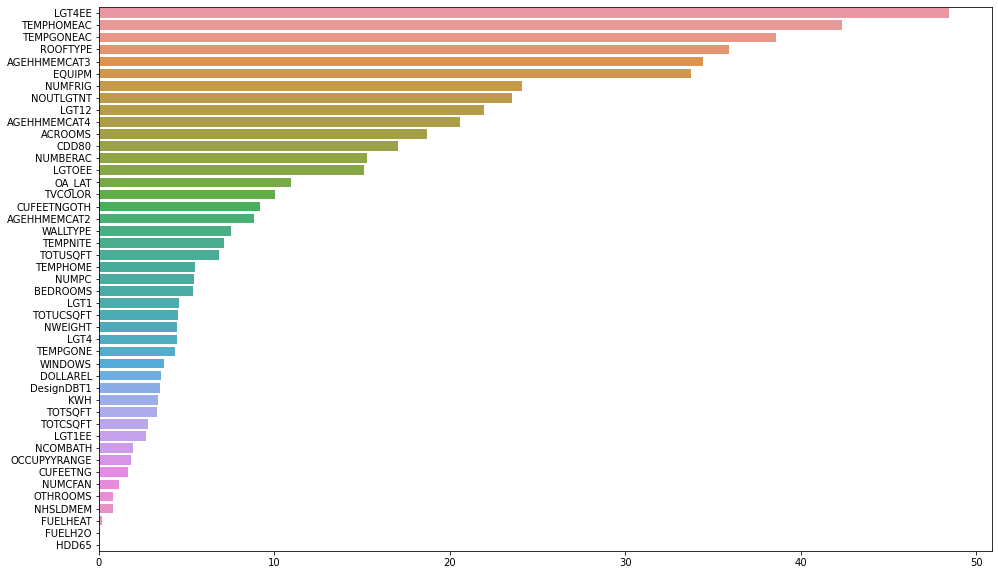

In [33]:
# sort the identified columns by their percentage of outliers (IQR based)
outlier_iqr_dic_sorted = {}
sorted_keys = sorted(outlier_iqr_dic, key=outlier_iqr_dic.get, reverse=True)

for w in sorted_keys:
    outlier_iqr_dic_sorted[w] = outlier_iqr_dic[w]
    
# plot percentage of outliers
plt.figure(figsize=(16, 10))
sns.barplot(x=list(outlier_iqr_dic_sorted.values()), y=list(outlier_iqr_dic_sorted.keys()));

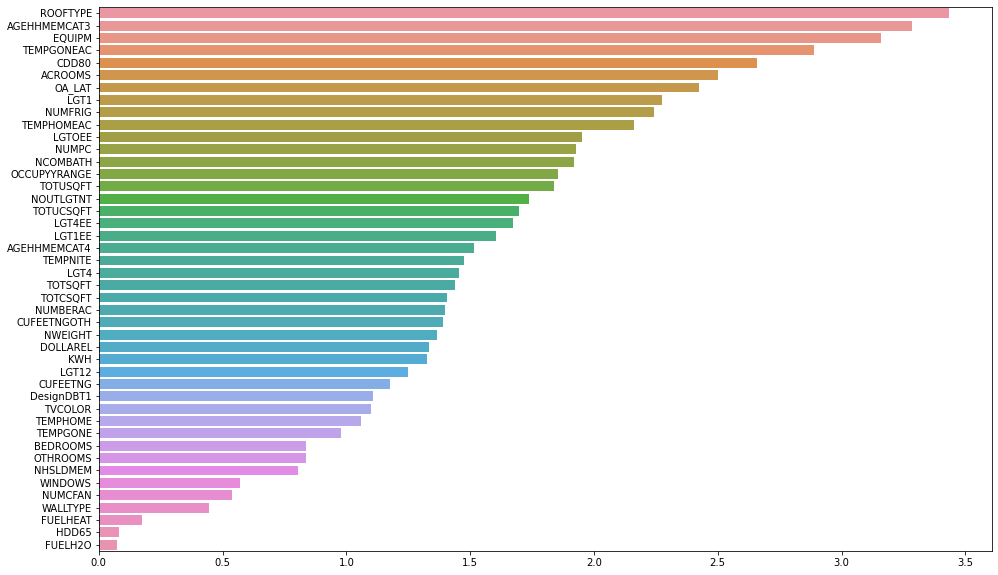

In [34]:
# sort the identified columns by their percentage of outliers (z-score based)
outlier_zscore_dic_sorted = {}
sorted_keys = sorted(outlier_zscore_dic, key=outlier_zscore_dic.get, reverse=True)

for w in sorted_keys:
    outlier_zscore_dic_sorted[w] = outlier_zscore_dic[w]
    
# plot percentage of outliers
plt.figure(figsize=(16, 10))
sns.barplot(x=list(outlier_zscore_dic_sorted.values()), y=list(outlier_zscore_dic_sorted.keys()));

Using the 1.5*IQR rule, the percentage of outliers is much higher. For instance, the `LGT4EE` variable has 48% outliers. Using the z-score<3 rule, the same variable has only 2% outliers.

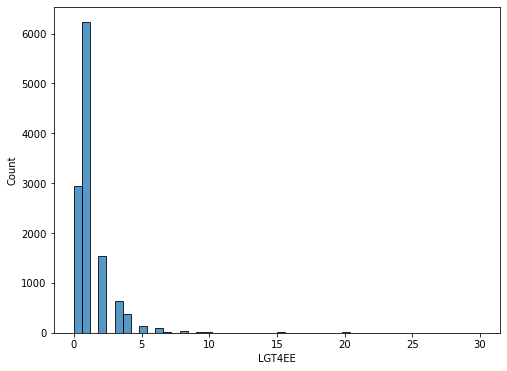

In [35]:
sns.histplot(df_clean['LGT4EE'],bins=50);

Looking at the histogram of `LGT4EE`, it makes more sense to use the z-score for outlier treatment. Using the z-score<3 rule, we will replace outliers by median values:

In [36]:
# clean outliers
print(df_clean.shape)
for col in outliers:
    clean_outliers_zscore(df_clean, col)
print(df_clean.shape)

(12083, 171)
(12083, 171)


## Remove Skewness of the Variables

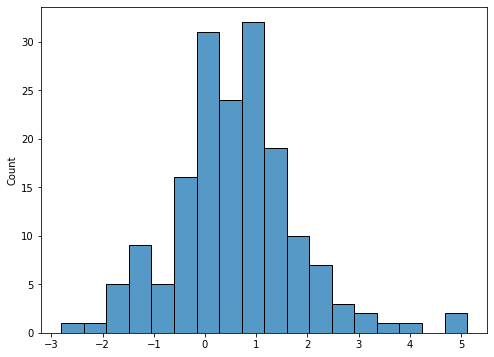

In [37]:
# distribution of the skewness of the variables
sns.histplot(df_clean.drop(columns=list(df_clean.select_dtypes(include='object').columns)).skew());

In [38]:
# list of skewed variables
skewed_cols = [col for col in df_clean.drop(columns=list(df_clean.select_dtypes(include='object').columns)).columns 
               if abs(df_clean[col].skew())>1]

len(skewed_cols)

73

In [39]:
# check if our target variable is among the skewed variables
'KWH' in skewed_cols

False

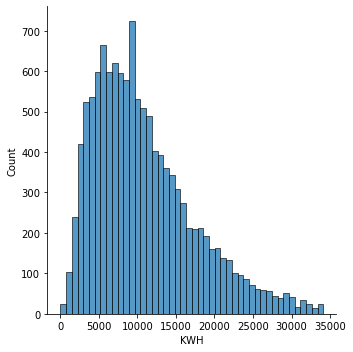

In [40]:
# distribution plot of the target 'KWH'
sns.displot(df_clean['KWH'])

The target variable `KWH` is right-skewed. We will convert it and all other skewed variables into log to reduce the skew in the dataset. This will be even more useful in the case of a linear regression, where the target variable is assumed to have a normal distribution.

In [41]:
skewed_cols = skewed_cols + ['KWH']
'KWH' in skewed_cols

True

In [42]:
print(df_clean.shape)
for col in skewed_cols:
    # this only works for positive values
    #df_clean[col + '_log'] = np.log(df_clean[col])
    
    # handle negative values in the log transformation
    df_clean[col + '_log'] = np.log(df_clean[col] + 1 - min(df_clean[col]))

df_clean.drop(columns=skewed_cols, inplace=True)
print(df_clean.shape)

(12083, 171)
(12083, 171)


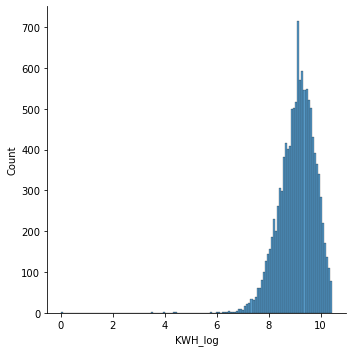

In [43]:
# distribution plot of the "new" target 'KWH_log'
sns.displot(df_clean['KWH_log']);

In [44]:
# clean outliers in the target 'KWH_log'
print(df_clean.shape)
clean_outliers_zscore(df_clean, 'KWH_log')
print(df_clean.shape)

(12083, 171)
(12083, 171)


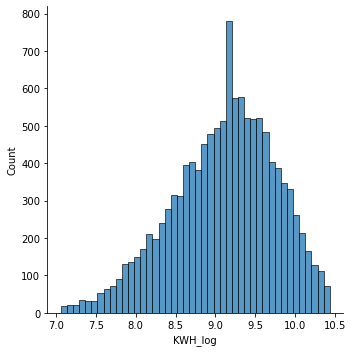

In [45]:
# distribution plot of the "new" target 'KWH_log'
sns.displot(df_clean['KWH_log']);

## Bivariate Analysis with Target `KWH_log`

### Numerical Value Relationship

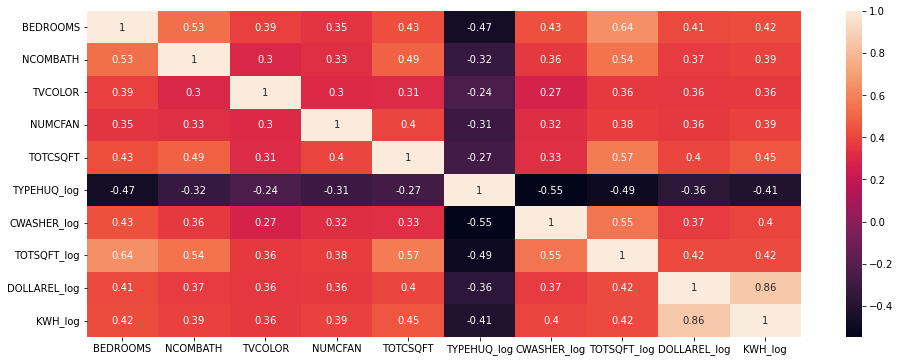

In [46]:
## analyze weak/moderatate to strong correlations to our target 'KWH_log'

# create correlation dataframe df_corr
df_corr = df_clean.corr()

# filter correlation dataframe to weak/moderatate to strong correlations to our target 'KWH_log'
relevant_cols = list(df_corr[abs(df_corr['KWH_log'])>=0.35].index)

# heatmap plot of the resulting correlations
plt.figure(figsize=(16, 6))
sns.heatmap(df_corr[relevant_cols][abs(df_corr['KWH_log'])>=0.35], annot=True);

Our target `KWH_log` has a positive correlation with
 - `BEDROOMS`: Number of bedrooms
 - `NCOMBATH`: Number of full bathrooms
 - `TVCOLOR`: Number of televisions used
 - `NUMCFAN`: Number of ceiling fans used
 - `TOTCSQFT`: Total cooled square footage
 - `CWASHER`: Clothes washer used in home
 - `TOTSQFT`: Total square footage
 - `DOLLAREL`: Total Electricity cost

and a negative correlation with
- `TYPEHUQ`: Type of housing unit (1: Mobile Home, 2: Single-Family Detached, 3: Single-Family Attached, 4: Apartment in Building with 2 - 4 Units, 5: Apartment in Building with 5+ Units)

In [47]:
# remove the target from the identified columns
relevant_cols.remove('KWH_log')
relevant_cols

['BEDROOMS',
 'NCOMBATH',
 'TVCOLOR',
 'NUMCFAN',
 'TOTCSQFT',
 'TYPEHUQ_log',
 'CWASHER_log',
 'TOTSQFT_log',
 'DOLLAREL_log']

In [48]:
# divide the identified columns into continuous and discrete lists (for better plots)
relevant_num_cols = [col for col in relevant_cols if df_clean[col].nunique()>=30]
relevant_int_cols = [col for col in relevant_cols if df_clean[col].nunique()<30]

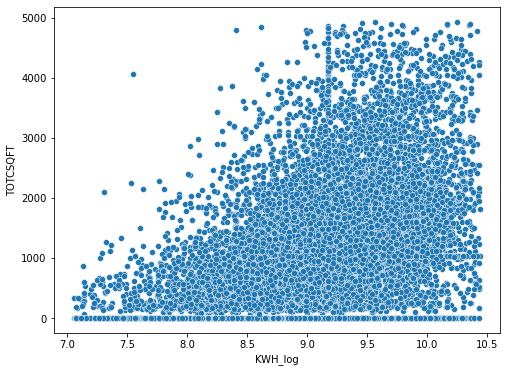

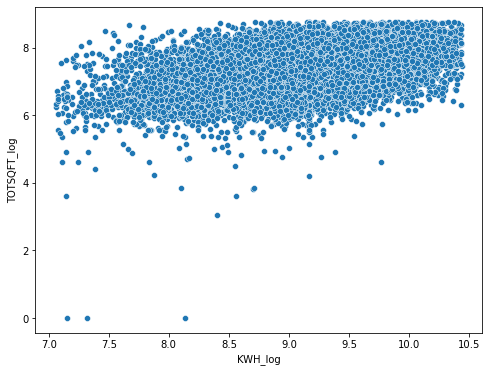

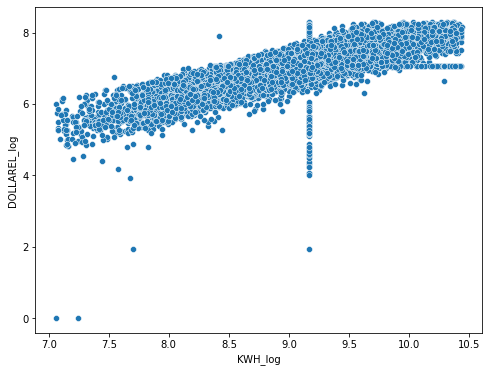

In [49]:
# scatter plots between the target and the identified continuous variables
for col in relevant_num_cols:
    plt.figure()
    sns.scatterplot(data=df_clean, x='KWH_log', y=col);

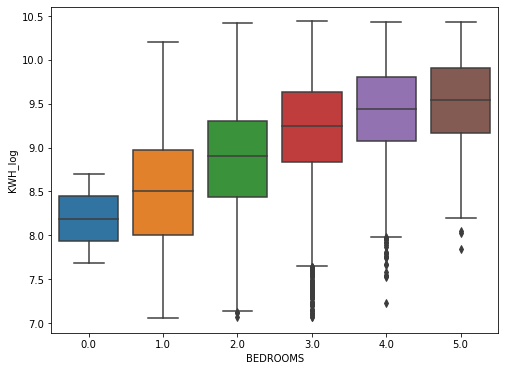

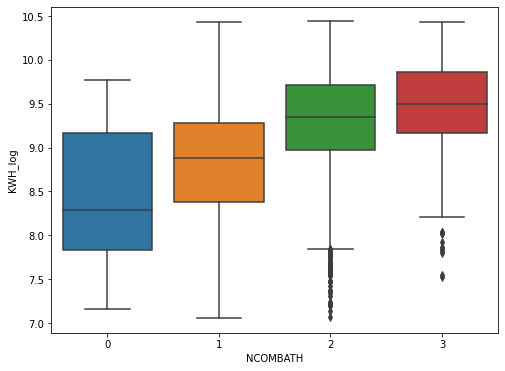

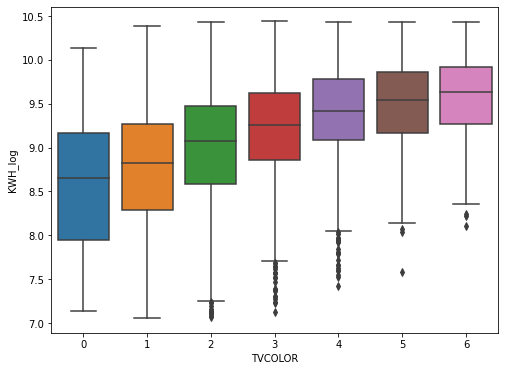

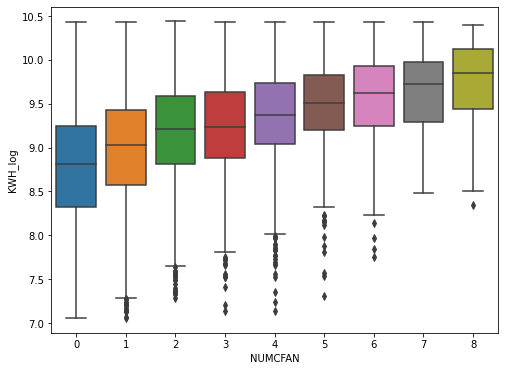

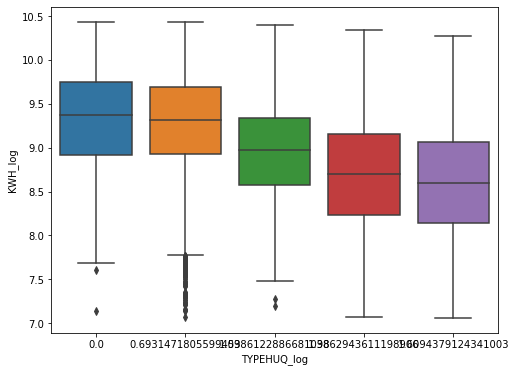

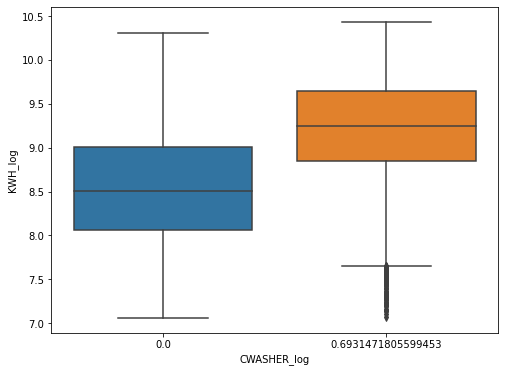

In [50]:
# box plots between the target and the identified discrete variables
for col in relevant_int_cols:
    plt.figure()
    sns.boxplot(x=col, y='KWH_log', data=df_clean);

### Categorical Value Relationship

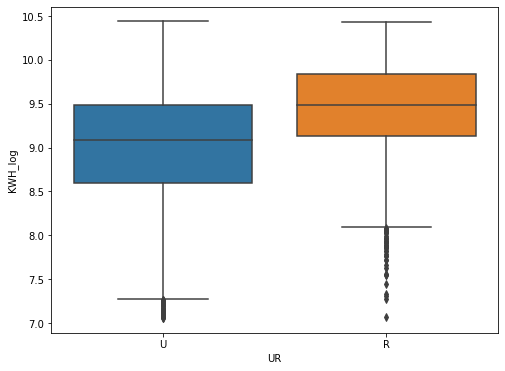

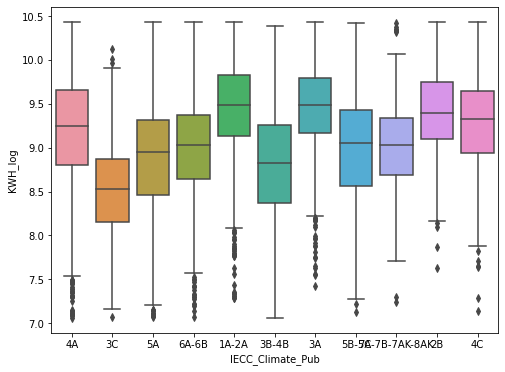

In [51]:
# box plots between the target and the categorical variables
for col in df_clean.select_dtypes(include='object').columns:
    plt.figure()
    sns.boxplot(x=col, y='KWH_log', data=df_clean);

## Analyze and Encode Categorical Columns

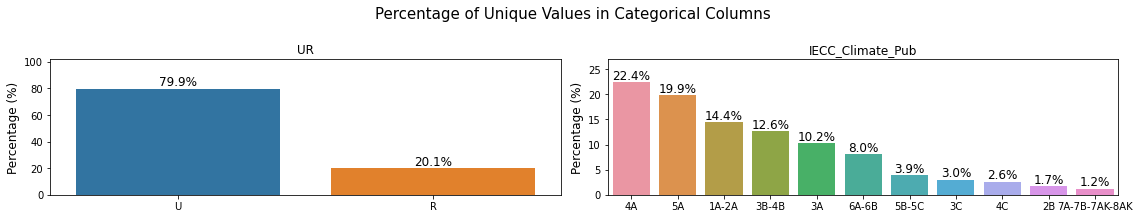

In [52]:
# calculate and plot (bar plot) the percentage of unique values in categorical columns

i=0
n_cols = 2

fig, ax = plt.subplots(math.ceil((len(df_clean.select_dtypes(include='object').columns)/n_cols)), n_cols, figsize=(16,3))
fig.suptitle('Percentage of Unique Values in Categorical Columns', fontsize=15, y=1.)

for col in df_clean.select_dtypes(include='object').columns:
    df_col = df_clean[col].value_counts(normalize=True).mul(100).rename('Percentage (%)').reset_index()
 
    g = sns.barplot(x='index', y='Percentage (%)', data=df_col, ax=ax[i])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_title(col, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('Percentage (%)', fontsize = 12)
    
    # add percentages as text to the bars
    for container in g.containers:
        g.bar_label(container, fmt='%.1f%%', fontsize=12)
    bottom, upper = g.get_ylim()
    g.set_ylim(bottom, upper+2)
    plt.subplots_adjust(hspace=5)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if len(df_clean.select_dtypes(include='object').columns)%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()

fig.tight_layout()

There are two categorical columns with 2 and 11 categories, respectively. We convert them into dummy/indicator variables:

In [53]:
# encode categorical variables
print(df_clean.shape)
df_encoded = pd.get_dummies(df_clean, drop_first=True)
print(df_encoded.shape)

(12083, 171)
(12083, 180)


# Modeling

## Train - Test - Split

In [54]:
# define feature matrix X and target column y
X = df_encoded.drop(columns=['KWH_log'])
y = df_encoded['KWH_log']

In [55]:
# split X and y into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(9666, 179)
(2417, 179)
(9666,)
(2417,)


## Feature Selection

In [56]:
# create linear regression object
lr = LinearRegression()

# create Sequential Feature Selection object using the "best" 30 features
sfs = SFS(lr, 
          k_features=30, 
          forward=True,
          scoring='neg_root_mean_squared_error')

In [57]:
# perform Sequential Feature Selection
sfs.fit(X_train,y_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=30,
                          scoring='neg_root_mean_squared_error')

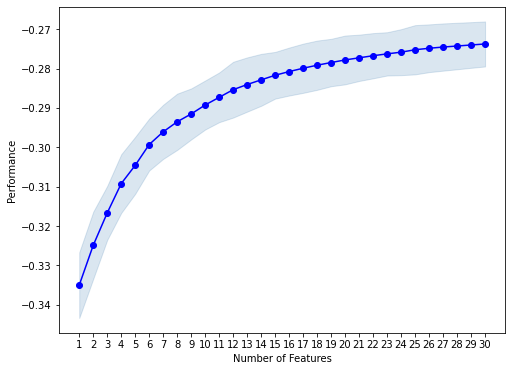

In [58]:
# plot the results from Sequential Feature Selection
plot_sfs(sfs.get_metric_dict());

In [59]:
# prediction score
sfs.k_score_

-0.27375893112460525

In [60]:
# show the "best" 30 features
selected_features = []
for i in list(sfs.k_feature_idx_):
    selected_features.append(X.columns[i])
    
selected_features

['REGIONC',
 'HDD65',
 'Climate_Region_Pub',
 'OTHROOMS',
 'OUTGRILL',
 'SEPFREEZ',
 'WASHLOAD',
 'TVCOLOR',
 'TEMPNITE',
 'FUELH2O',
 'PROTHERMAC',
 'NUMCFAN',
 'ELWARM',
 'NHSLDMEM',
 'TOTCSQFT',
 'DesignDBT1',
 'TYPEHUQ_log',
 'NWEIGHT_log',
 'EQUIPM_log',
 'CARRYEL_log',
 'USECENAC_log',
 'LGT12_log',
 'INVESTMT_log',
 'DOLLAREL_log',
 'CUFEETNGOTH_log',
 'CDD80_log',
 'IECC_Climate_Pub_3B-4B',
 'IECC_Climate_Pub_3C',
 'IECC_Climate_Pub_4A',
 'IECC_Climate_Pub_5A']

## Final Linear Regression Model

In [61]:
# we select the best 25 features for our final model
model_features = selected_features[:25]
model_features

['REGIONC',
 'HDD65',
 'Climate_Region_Pub',
 'OTHROOMS',
 'OUTGRILL',
 'SEPFREEZ',
 'WASHLOAD',
 'TVCOLOR',
 'TEMPNITE',
 'FUELH2O',
 'PROTHERMAC',
 'NUMCFAN',
 'ELWARM',
 'NHSLDMEM',
 'TOTCSQFT',
 'DesignDBT1',
 'TYPEHUQ_log',
 'NWEIGHT_log',
 'EQUIPM_log',
 'CARRYEL_log',
 'USECENAC_log',
 'LGT12_log',
 'INVESTMT_log',
 'DOLLAREL_log',
 'CUFEETNGOTH_log']

In [62]:
# restrict the train and test data to our selected features
X_train = X_train[model_features].copy()
X_test = X_test[model_features].copy()

In [63]:
# perform linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)

# predict the test set
lr_predict = lr.predict(X_test)

# Evaluation

In [64]:
# R2 Scores (R-squared) and RMSEs (root mean squared errors)
print('R2 Score Train: {:.6f}'.format(lr.score(X_train,y_train)))
print('RMSE Train: {:.6f}'.format(mean_squared_error(y_train, lr.predict(X_train), squared=False)))
print('='*25)
print('R2 Score Test: {:.6f}'.format(lr.score(X_test,y_test)))
print('RMSE Test: {:.6f}'.format(mean_squared_error(y_test, lr.predict(X_test), squared=False)))

R2 Score Train: 0.818932
RMSE Train: 0.275574
R2 Score Test: 0.821602
RMSE Test: 0.274240


- R-squared, which measures the proportion of variation in the data that is accounted for in the model, is 0.818932.
- RMSE, which measures the average distance between the predicted values from the model and the actual values in the dataset, is 0.275574.

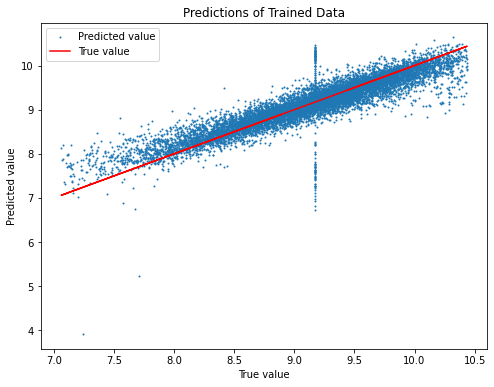

In [65]:
# plot predicted and true values for the train set
plt.scatter(x=y_train, y=lr.predict(X_train), s=1.)
plt.plot(y_train,y_train, c='red')
plt.legend(['Predicted value','True value'])
plt.title('Predictions of Trained Data')
plt.xlabel('True value')
plt.ylabel('Predicted value');

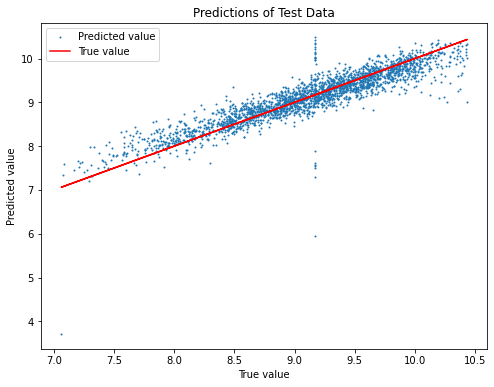

In [66]:
# plot predicted and true values for the test set
plt.scatter(x=y_test, y=lr.predict(X_test), s=1.)
plt.plot(y_test, y_test, c='red')
plt.legend(['Predicted value','True value'])
plt.title('Predictions of Test Data')
plt.xlabel('True value')
plt.ylabel('Predicted value');

In [67]:
# print intercept of the linear regression model
print('Intercept: {:.6f}'.format(lr.intercept_))

Intercept: 2.703807


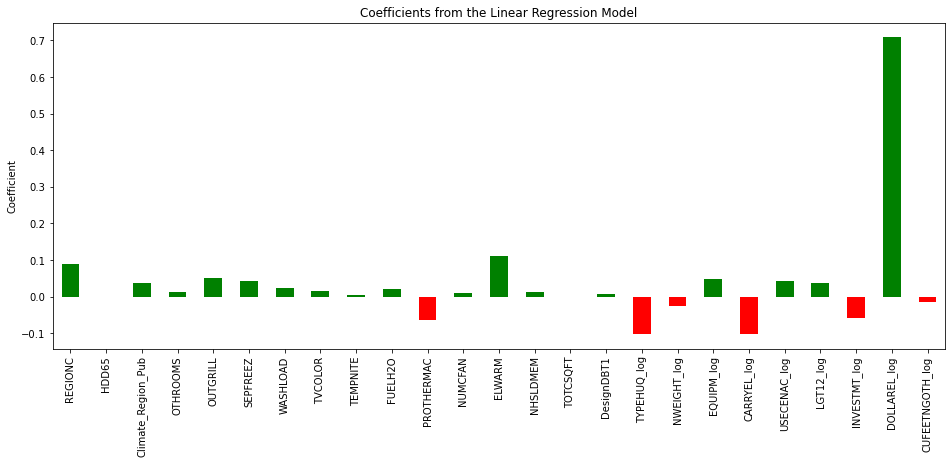

In [68]:
# plot coefficients of the linear regression model
df_coeff = pd.DataFrame({'columns': X_train.columns.tolist(), 'coefficients': lr.coef_.tolist()})

df_coeff.plot.bar(x='columns', y='coefficients', legend=False, figsize=(16, 6),
                 color=(df_coeff['coefficients'] > 0).map({True: 'g', False: 'r'}));
plt.xticks(rotation = 90);
plt.ylabel('Coefficient')
plt.title('Coefficients from the Linear Regression Model')
plt.xlabel('')
plt.show();

**Negative correlations:**

`KWH` (total site electricity usage)  increases as the following variables decrease:
 - `PROTHERMAC` (Programmable main thermostat): 0=no, 1=yes
 - `TYPEHUQ` (Type of housing unit): 1=Mobile Home, 2=Single-Family Detached, 3=Single-Family Attached, 4=Apartment in Building with 2 - 4 Units, 5=Apartment in Building with 5+ Units
 - `NWEIGHT` (Final sample weight)
 - `CARRYEL` (Portable electric heaters used for secondary space heating): 0=no, 1=yes
 - `INVESTMT` (Household members received investment income in 2009): 0=no, 1=yes
 - `CUFEETNGOTH` (Natural Gas usage for other purposes)
    
I would have expected a positive correlation between `TYPEHUQ` and `KWH` or between `CARRYEL` and `KWH`.

In [69]:
# using 'statsmodels', we get a more detailed analysis
model = sm.OLS(y_train, X_train.assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                KWH_log   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     1744.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        14:50:25   Log-Likelihood:                -1257.0
No. Observations:                9666   AIC:                             2566.
Df Residuals:                    9640   BIC:                             2753.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
REGIONC                0.0892      0.004     24.655      0.000       0.082       0.096
HDD65               4.224e-05   1.85e-06     22.869      0.000    3.86e-05    4.59e-05
Climate_Region_Pub     0.0388      0.002     16.278      0.000       0.034       0.043
OTHROOMS               0.0138      0.003      5.173      0.000       0.009       0.019
OUTGRILL               0.0508      0.007      7.448      0.000       0.037       0.064
SEPFREEZ               0.0443      0.007      6.512      0.000       0.031       0.058
WASHLOAD               0.0243      0.004      5.956      0.000       0.016       0.032
TVCOLOR                0.0159      0.003      6.059      0.000       0.011       0.021
TEMPNITE               0.0043      0.001      7.002      0.000       0.003       0.005
FUELH2O                0.0205      0.002     10.402      0.000       0.017       0.024
PROTHERMAC            -0.0640      0.007     -9.469      0.000      -0.077      -0.051
NUMCFAN                0.0111      0.002      6.429      0.000       0.008       0.015
ELWARM                 0.1118      0.008     14.095      0.000       0.096       0.127
NHSLDMEM               0.0119      0.002      4.927      0.000       0.007       0.017
TOTCSQFT            5.002e-05   3.54e-06     14.130      0.000    4.31e-05     5.7e-05
DesignDBT1             0.0063      0.001     11.293      0.000       0.005       0.007
TYPEHUQ_log           -0.1016      0.008    -12.238      0.000      -0.118      -0.085
NWEIGHT_log           -0.0263      0.006     -4.670      0.000      -0.037      -0.015
EQUIPM_log             0.0471      0.007      6.455      0.000       0.033       0.061
CARRYEL_log           -0.1017      0.013     -7.941      0.000      -0.127      -0.077
USECENAC_log           0.0439      0.007      6.030      0.000       0.030       0.058
LGT12_log              0.0368      0.007      5.198      0.000       0.023       0.051
INVESTMT_log          -0.0575      0.010     -5.684      0.000      -0.077      -0.038
DOLLAREL_log           0.7080      0.006    114.010      0.000       0.696       0.720
CUFEETNGOTH_log       -0.0138      0.002     -8.796      0.000      -0.017      -0.011
const                  2.7038      0.092     29.233      0.000       2.523       2.885
==============================================================================
Omnibus:                     3300.246   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56724.898
Skew:                           1.184   Prob(JB):                         0.00
Kurtosis:                      14.629   Cond. No.                     1.60e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correct

- The adjusted R-squared, which adjusts for the degrees of freedom, is 0.818.
- The p-values indicate that all selected features are significant.

**Next Steps to Improve the Model:**
- Better understanding of the variables
- More careful handling of Don't Know/Refuse/Not Applicable responses
- Identify nominal categorical variables (no intrinsic ordering)
- Outlier treatment
- Nonlinear features and interactions between variables
- Principal component analysis (PCA)
- Combine similar categories
- Compare other regression models, such as tree models
- Clustering to identify subsets on which regression may/should be performed separately